In [18]:
import os
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datetime import datetime
import pandas as pd

In [2]:
auth = earthaccess.login()
# are we authenticated?
if auth.authenticated:
    print("authenticated!")
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

Enter your Earthdata Login username:  fmiller_bigelow
Enter your Earthdata password:  ········


authenticated!


In [6]:
results = earthaccess.search_datasets(instrument="oci")

In [7]:
for item in results:
    summary = item.summary()
    print(summary["short-name"])

PACE_OCI_L2_BGC_NRT
PACE_OCI_L0_SCI
PACE_OCI_L1A_SCI
PACE_OCI_L1B_SCI
PACE_OCI_L1C_SCI
PACE_OCI_L2_AOP_NRT
PACE_OCI_L2_IOP_NRT
PACE_OCI_L2_PAR_NRT
PACE_OCI_L3B_CHL_NRT
PACE_OCI_L3B_IOP_NRT
PACE_OCI_L3B_KD_NRT
PACE_OCI_L3B_PAR_NRT
PACE_OCI_L3B_POC_NRT
PACE_OCI_L3B_RRS_NRT
PACE_OCI_L3M_CHL_NRT
PACE_OCI_L3M_IOP_NRT
PACE_OCI_L3M_KD_NRT
PACE_OCI_L3M_PAR_NRT
PACE_OCI_L3M_POC_NRT
PACE_OCI_L3M_RRS_NRT


In [8]:
tspan = ("2024-07-01", "2024-08-25")
bbox = (-170, 23, -140, 33)

In [9]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_RRS_NRT",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*.0p1deg.*",
)

paths = earthaccess.open(results)[1:5]

QUEUEING TASKS | :   0%|          | 0/56 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/56 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/56 [00:00<?, ?it/s]

In [10]:
paths

[<File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240702.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240703.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240704.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240705.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>]

In [23]:
import xarray as xr
from datetime import datetime

# Use dask for lazy loading
combined_datasets = []
dates = []

# Iterate over all the datasets
for i in range(1, len(paths)):
    # Open dataset without specifying chunks
    dataset = xr.open_dataset(paths[i])

    # Rechunk the dataset after loading
    dataset = dataset.chunk({'lon': 'auto', 'lat': 'auto'})  # Use 'auto' or set specific sizes
    
    # Subset the dataset within the specified region and append to list
    subset = dataset.sel(lon=slice(-159.5, -157.5), lat=slice(27.5, 26))

    # Extract the date and convert to datetime
    date = subset.attrs['time_coverage_start']
    date = datetime.fromisoformat(date.replace("_", "T"))  # Convert to datetime

    # Append the subset to the list of datasets
    combined_datasets.append(subset)
    
    # Keep track of the dates separately
    dates.append(date)

# Concatenate all subsets along a new dimension, e.g., 'dataset'
combined_dataset = xr.concat(combined_datasets, dim='dataset')

# Calculate the mean Rrs value across lon and lat for each dataset
average_per_dataset = combined_dataset.mean(dim=['lon', 'lat'])

# Add dates as a coordinate to the averaged dataset
average_per_dataset = average_per_dataset.assign_coords(datetime=('dataset', dates))


In [24]:
average_per_dataset

<xarray.Dataset>
Dimensions:     (wavelength: 184, dataset: 3, rgb: 3, eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 339.0 341.0 344.0 ... 714.0 717.0 719.0
Dimensions without coordinates: dataset, rgb, eightbitcolor
Data variables:
    Rrs         (dataset, wavelength) float32 dask.array<chunksize=(1, 184), meta=np.ndarray>
    palette     (dataset, rgb, eightbitcolor) uint8 dask.array<chunksize=(1, 3, 256), meta=np.ndarray>

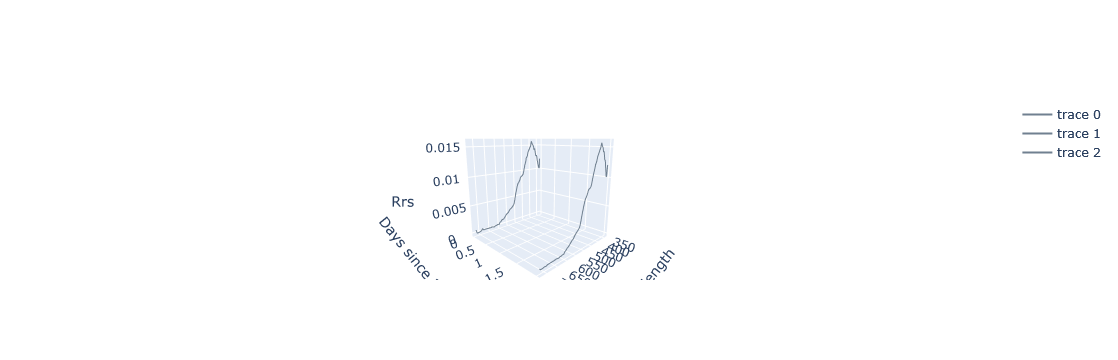

In [25]:
#Previous version
import plotly.graph_objects as go
import numpy as np

# Assuming average_per_dataset is already created using Dask
wavelengths = average_per_dataset['wavelength'].values
rrs_values = average_per_dataset['Rrs'].compute()  # Trigger computation for all datasets
y_indices = np.arange(rrs_values.shape[0])  # Create an array of dataset indices
dates = pd.date_range(start='2024-01-01', periods=10, freq='D')  # Example dates
dates = pd.to_datetime(dates)


# Create a 3D scatter plot
fig = go.Figure()

for dataset_index in range(rrs_values.shape[0]):
    fig.add_trace(go.Scatter3d(
        x=wavelengths,
        y=[dates[dataset_index]] * len(wavelengths),  # Repeat date for each wavelength
        z=rrs_values[dataset_index],
        mode='lines',
        line=dict(color='slategray')
    ))

# Update layout with larger figure size
fig.update_layout(
    scene=dict(
        xaxis_title='Wavelength',
        yaxis_title='Date',
        zaxis_title='Rrs',
        yaxis=dict(
            tickformat='%Y-%m-%d',  # Format y-axis ticks as dates
            type='date'  # Ensure y-axis treats values as dates
        )
    ),
    width=1200,  # Width of the plot in pixels
    height=800,  # Height of the plot in pixels
)

fig.show()

In [28]:
import xarray as xr
from datetime import datetime

# Use dask for lazy loading
combined_datasets = []
dates = []

# Iterate over all the datasets
for i in range(1, len(paths)):
    # Open dataset without specifying chunks
    dataset = xr.open_dataset(paths[i])

    # Rechunk the dataset after loading
    dataset = dataset.chunk({'lon': 'auto', 'lat': 'auto'})  # Use 'auto' or set specific sizes
    
    # Subset the dataset within the specified region and append to list
    subset = dataset.sel(lon=slice(-159.5, -157.5), lat=slice(27.5, 26))

    # Extract the date and convert to datetime
    date = subset.attrs['time_coverage_start']
    date = datetime.fromisoformat(date.replace("_", "T"))  # Convert to datetime

    # Append the subset to the list of datasets
    combined_datasets.append(subset)
    
    # Keep track of the dates separately
    dates.append(date)

# Concatenate all subsets along a new dimension, e.g., 'dataset'
combined_dataset = xr.concat(combined_datasets, dim='dataset')

# Calculate the mean Rrs value across lon and lat for each dataset
average_per_dataset = combined_dataset.mean(dim=['lon', 'lat'])

# Add dates as a coordinate to the averaged dataset
average_per_dataset = average_per_dataset.assign_coords(datetime=('dataset', dates))


In [30]:
average_per_dataset

<xarray.Dataset>
Dimensions:     (wavelength: 184, dataset: 3, rgb: 3, eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 339.0 341.0 344.0 ... 714.0 717.0 719.0
    datetime    (dataset) object 2024-07-02T23:30:49+00:00 ... 2024-07-05T00:...
Dimensions without coordinates: dataset, rgb, eightbitcolor
Data variables:
    Rrs         (dataset, wavelength) float32 dask.array<chunksize=(1, 184), meta=np.ndarray>
    palette     (dataset, rgb, eightbitcolor) uint8 dask.array<chunksize=(1, 3, 256), meta=np.ndarray>

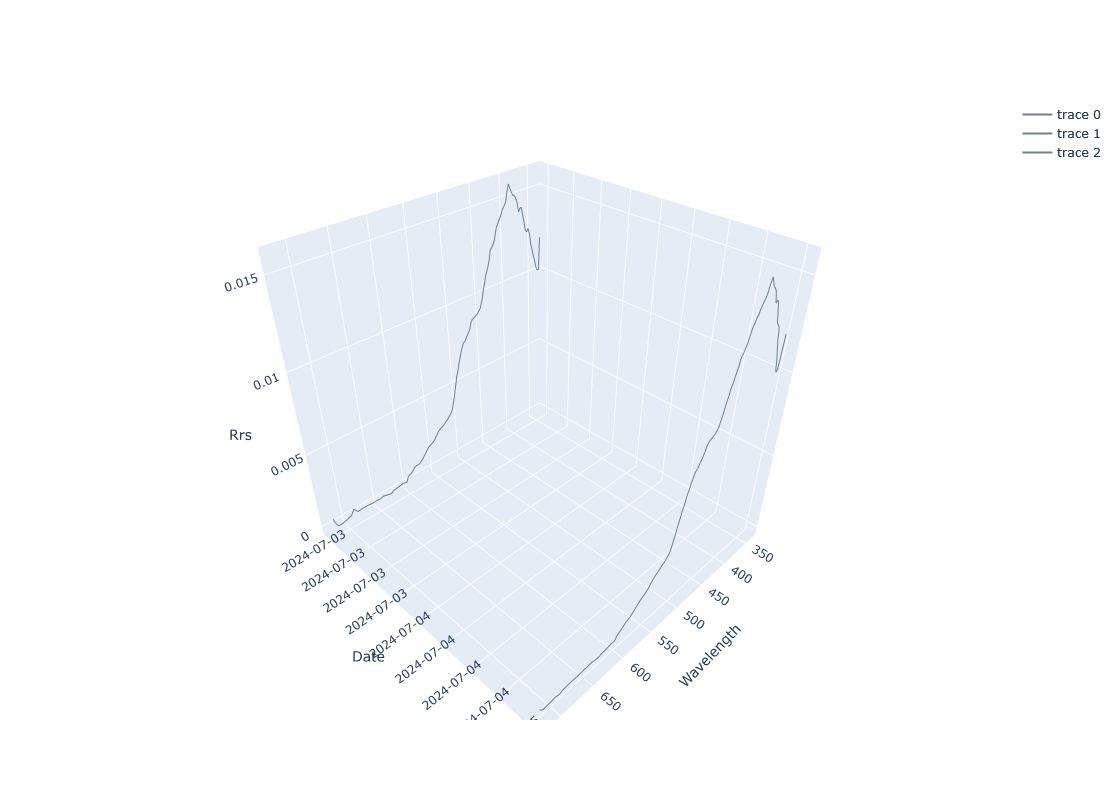

In [29]:
import plotly.graph_objects as go

# Extract values for plotting
wavelengths = average_per_dataset['wavelength'].values
rrs_values = average_per_dataset['Rrs'].compute()
dates = average_per_dataset['datetime'].values

# Create a 3D scatter plot
fig = go.Figure()

for dataset_index in range(rrs_values.shape[0]):
    fig.add_trace(go.Scatter3d(
        x=wavelengths,
        y=[dates[dataset_index]] * len(wavelengths),  # Use the date for each dataset
        z=rrs_values[dataset_index],
        mode='lines',
        line=dict(color='slategray')
    ))

fig.update_layout(
    scene=dict(
        xaxis_title='Wavelength',
        yaxis_title='Date',
        zaxis_title='Rrs',
        yaxis=dict(
            tickformat='%Y-%m-%d',  # Format y-axis ticks as dates
            type='date'  # Ensure y-axis treats values as dates
        )
    ),
    width=1200,
    height=800,
)

fig.show()
